# Activity 1.2: Bootstrap
Last modified (13 Feb 2023)

### Learning Outcomes

In this activity we learn how to:

- define a repeated data splitting (cross validation) scheme in `scikit-learn`
- implement the Bootstrap in the splitter framework (using `numpy`)
- apply the Bootstrap to more reliably estimate the effect of a hyper-parameter (using [`sklearn.model_selection.cross_validate`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate))
- plot the results of an experiment with error bars using `matplotlib`
- choose a suitable number of Bootstrap repetitions
- describe how the number of training data influences the choice for $k$ in $k$-NN

### Preliminaries

- Activity 1.1
- Lecture 2

## Introduction

In the previous activity we have determined that drawing conclusions about predictive performance from a single train/test split is risky, because our error estimates will often have a large variance. Here, the source of randomness is the specific split but also the overall data sample we got in the first place (imagine Fisher would have obtained a second sample of Iris flowers; would it have been identical to the first one?). 

Therefore, we now look at more systematic to obtain error estimates that take this variation over possible training sets into account. In Chapter 3, we have learned that Bootstrapping is a powerful statistical tool that helps us to measure the uncertainty in the prediction of a model. In this activity, we implement this technique to assess variations in the prediction of KNN classifier. In **Assignment Task 2.B.**, you will be asked to expand this example and develop a bootstrap procedure for KNN as a regressor. 

### Outline

- Before turning to the Bootstrap, we will first learn how data splitting and subsampling strategies are generally described and implemented in `scikit-learn`. 
- We will demonstrate that using again the Iris dataset and the $k$-NN classifier. Instead of re-implementing $k$-NN, this time we will simply use the implementation from `scikit-learn`.
- Then we will implement a Bootstrap splitting scheme and evaluate the effect of the number of repetitions and training size in determining what is the best value for $k$.

## Data splitters in `scikit-learn`

In the framework of `scikit-learn`, the Boostrap can be considered a particular cross validation scheme where we repeatedly generate training sets via index sampling with replacement and use the unsampled indices in a given iteration as test indices. 

Such schemes are implemented in `skikit-learn` as `Splitter` objects that provide two methods:

- `get_n_splits(x=None, y=None, groups=None)` which informs about how many splits the splitter would produce for the given dataset; here all parameters are optional as the splits (often) do not depend on the given number
- `split(x, y=None, groups=None)` which is a [generator function](https://docs.python.org/3/reference/expressions.html?highlight=yield%20statement#yield-expressions) that yields a sequence of training and test indices

As an illustration let us look at the class `ShuffleSplit` and use it with the Iris dataset. This splitting scheme allows as to perform a simple training/test split akin to what we have implemented in Activity 1.1. However, it conveniently allows for repetitions of the splitting process to increase our confidence in the result.

In [1]:
from sklearn.datasets import load_iris
from sklearn.model_selection import ShuffleSplit

iris = load_iris()
shuffleSplit = ShuffleSplit(n_splits=2, train_size=0.6, random_state=0)
print('Shuffle split will generate', shuffleSplit.get_n_splits(), 'splits.')
for i, (train_idx, test_idx) in enumerate(shuffleSplit.split(iris.data)):
    print('split', i)
    print('train indices', train_idx)
    print('test indices', test_idx)

Shuffle split will generate 2 splits.
split 0
train indices [ 85  30 101  94  64  89  91 125  48  13 111  95  20  15  52   3 149  98
   6  68 109  96  12 102 120 104 128  46  11 110 124  41 148   1 113 139
  42   4 129  17  38   5  53 143 105   0  34  28  55  75  35  23  74  31
 118  57 131  65  32 138  14 122  19  29 130  49 136  99  82  79 115 145
  72  77  25  81 140 142  39  58  88  70  87  36  21   9 103  67 117  47]
test indices [114  62  33 107   7 100  40  86  76  71 134  51  73  54  63  37  78  90
  45  16 121  66  24   8 126  22  44  97  93  26 137  84  27 127 132  59
  18  83  61  92 112   2 141  43  10  60 116 144 119 108  69 135  56  80
 123 133 106 146  50 147]
split 1
train indices [  7  45 129 103 146 120  94  50 134  99 126 114   9  39  97 101  29  81
  20  46  51  53  23  27   2  28  37 111  10  84 137 127  43  87  69 144
 140  35  76   3  82 145 116  88  44 147   1  93  38  11 115  54  40  18
  41  79  24  56  71  13  31  85  70 132 125 123 100  32 104  83 117 118
 1

While we could use such a splitter in an explicit loop as above to run an experiment, it is often more convenient to use the function [`sklearn.model_selection.cross_valide`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate). Let us demonstrate this function with 5 repetitions of shuffle splitting.

In [2]:
from sklearn.model_selection import cross_validate
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(3)
shuffleSplit5 = ShuffleSplit(n_splits=5, train_size=0.6, random_state=0)
cross_validate(knn, iris.data, iris.target, cv=shuffleSplit5, return_train_score=True)

{'fit_time': array([0.00067687, 0.00046611, 0.00040078, 0.00037384, 0.00044274]),
 'score_time': array([0.00243211, 0.00198579, 0.00192404, 0.00188398, 0.0020771 ]),
 'test_score': array([0.93333333, 0.93333333, 0.98333333, 0.93333333, 0.96666667]),
 'train_score': array([0.98888889, 0.96666667, 0.94444444, 0.96666667, 0.95555556])}

We see that `cross_validate` returns a dictionary that not only contains the test and train prediction metrics for all repetitions defined by the splitter but also the time that was needed for fitting and prediction (which will be useful when aiming to optimise an implementation.

One thing that is noteworthy is that the metric used here is not the error rate but the the inverse accuracy metric, i.e., one minus the error rate. Below we show how we can provide our own metric based on providing a per-data-point error (or loss) function. Here, we use the zero-one error, which results in our familiar error rate as score.

In [3]:
from sklearn.metrics import make_scorer, zero_one_loss

cross_validate(knn, iris.data, iris.target, cv=shuffleSplit5, return_train_score=True, scoring=make_scorer(zero_one_loss))

{'fit_time': array([0.0007658 , 0.00049496, 0.00052881, 0.00050998, 0.00051808]),
 'score_time': array([0.00347924, 0.00226498, 0.00218105, 0.00250578, 0.00218201]),
 'test_score': array([0.06666667, 0.06666667, 0.01666667, 0.06666667, 0.03333333]),
 'train_score': array([0.01111111, 0.03333333, 0.05555556, 0.03333333, 0.04444444])}

## Implementing the Bootstrap

#### Task A: Complete the Implementation of the bootstrap splitter

**Insert the line in the Bootstrap splitter implementation below that generates the train indices in a given iteration**

Hint: You can go back to Activity 1.1 to remind yourself how we have performed the single train/test split. What parameter has to change to sample the training indices for the Bootstrap.

In [4]:
import numpy as np

class BootstrapSplitter:

    def __init__(self, reps, train_size, random_state=None):
        self.reps = reps
        self.train_size = train_size
        self.RNG = np.random.default_rng(random_state)

    def get_n_splits(self):
        return self.reps

    def split(self, x, y=None, groups=None):
        for _ in range(self.reps):
            train_idx = self.RNG.choice(np.arange(len(x)), size=round(self.train_size*len(x)), replace=True)
            test_idx = np.setdiff1d(np.arange(len(x)), train_idx)
            np.random.shuffle(test_idx)
            yield train_idx, test_idx


In [5]:
bootstrap = BootstrapSplitter(5, 0.6, random_state=0)
cross_validate(knn, iris.data, iris.target, cv=bootstrap, return_train_score=True, scoring=make_scorer(zero_one_loss))

{'fit_time': array([0.00086188, 0.00062203, 0.00073814, 0.00061703, 0.00075698]),
 'score_time': array([0.00546908, 0.00393486, 0.00545979, 0.00406718, 0.00578618]),
 'test_score': array([0.04819277, 0.03614458, 0.04938272, 0.03658537, 0.02380952]),
 'train_score': array([0.01111111, 0.01111111, 0.01111111, 0.01111111, 0.02222222])}

## Application to Test the Effect of $k$ in $k$-NN

The following function allows us to run a series of bootstrap experiments, one for each value of $k$.

In [6]:
def evaluation(max_k, cv):
    r = cv.get_n_splits()
    test_results = np.zeros(shape=(r, max_k))
    train_results = np.zeros(shape=(r, max_k))
    for k in range(1, max_k+1):
        knn = KNeighborsClassifier(k)
        cv_res = cross_validate(knn, iris.data, iris.target, cv=cv, return_train_score=True, scoring=make_scorer(zero_one_loss))
        test_results[:, k-1] = cv_res['test_score']
        train_results[:, k-1] = cv_res['train_score']

    return train_results, test_results

reps=25
max_k=30
train_results, test_results = evaluation(max_k=max_k, cv=BootstrapSplitter(reps, 0.6, random_state=0))


## Visualising the Results

When visualising the results of the experiments we now can compute meaningful error bars for each estimated performance due to the performed repetitions. This can be done with the `matplotlib`-function `errorbar`.

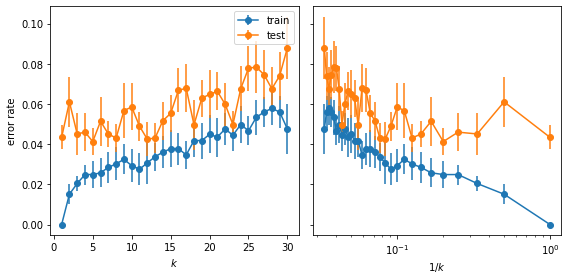

In [7]:
from matplotlib import pyplot as plt

ks = np.arange(1, max_k+1)
_, axs = plt.subplots(1, 2, figsize=(8,4), tight_layout=True, sharey=True)
z = (reps**0.5)/1.96
axs[0].errorbar(ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
axs[0].errorbar(ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
axs[0].legend()
axs[0].set_xlabel('$k$')
axs[0].set_ylabel('error rate')
axs[1].errorbar(1/ks, train_results.mean(axis=0), yerr=train_results.std(axis=0)/z, marker='o', label='train')
axs[1].errorbar(1/ks, test_results.mean(axis=0), yerr=test_results.std(axis=0)/z, marker='o', label='test')
axs[1].set_xscale('log')
axs[1].set_xlabel('$1/k$')
plt.show()

An alternative visualisation that uses [boxplots](https://en.wikipedia.org/wiki/Box_plot), which can be plotted with the function [`matplotlib.pyplot.boxplot`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html). Since there are more details about the result distribution in a boxplot it makes sense to focus on one individual metric in such a plot (here we use the test error rate).

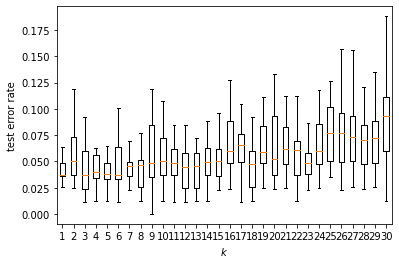

In [8]:
plt.boxplot(test_results, showfliers=False)
plt.ylabel('test error rate')
plt.xlabel('$k$')
plt.show()

## Effect of Bootstrap Repetitions

#### Task B: Give a hypothesis and rationale how changing the number of bootstrap repetitions will change the results of the experiment

*Increasing the number of bootstrap repetitions will smoothen the performance curve and reduce the error bars. The first is because we can assume that the true relationship between the $k$ and the error decreases smoothly and monotonically until the best value and will smoothly and monotonically increase afterwards. The second is simply because the estimated standard error of the performance estimates will be reduced as the square of the repetitions.*

#### Task C: Test your hypothesis by completing the experiment code below.

In [9]:
repetitions = [25, 50, 100]
train_results_reps = []
test_results_reps = []

for r in repetitions:
    print('reps: ', r)
    train_res, test_res = evaluation(max_k, BootstrapSplitter(r, 0.6, random_state=0))
    train_results_reps.append(train_res)
    test_results_reps.append(test_res)

reps:  25
reps:  50
reps:  100


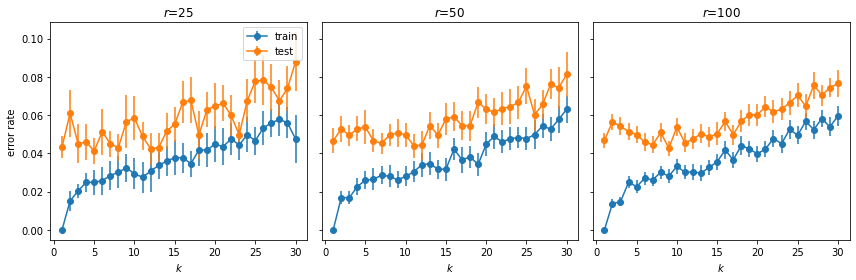

In [10]:
ks = np.arange(1, max_k+1)
_, axs = plt.subplots(1, len(repetitions), figsize=(4*len(repetitions),4), tight_layout=True, sharey=True)
for i, r in enumerate(repetitions):
    z = r**0.5/1.96
    axs[i].set_title(f'$r$={r}')
    axs[i].errorbar(ks, train_results_reps[i].mean(axis=0), yerr=train_results_reps[i].std(axis=0)/z, marker='o', label='train')
    axs[i].errorbar(ks, test_results_reps[i].mean(axis=0), yerr=test_results_reps[i].std(axis=0)/z, marker='o', label='test')
    axs[i].set_xlabel('$k$')
axs[0].legend()    
axs[0].set_ylabel('error rate')
plt.show()

## Effect of Train Size

#### Task D: Give a hypothesis and rationale how changing the train size will change the results of the experiment and in particular how it will influence what $k$ will achieve the best test performance.

*Increasing training sizes will overall reduce the error, because more training data means that the $k$ nearest neighbours will be closer to the corresponding test points. For the same reason the optimal $k$ should become larger, because even when including more neigbours those neighbours would still on average be close to a test point, and, at the same time, more neighbours help smoothing out the effect of indiviudal outliers.*

In [11]:
training_sizes = [0.4, 0.6, 0.8]
train_results_trainsize = []
test_results_trainsize = []
reps = 100

for frac in training_sizes:
    print('train size: ', round(len(iris.data)*frac))
    train_res, test_res = evaluation(max_k, BootstrapSplitter(reps, frac, random_state=1))
    train_results_trainsize.append(train_res)
    test_results_trainsize.append(test_res)

train size:  60
train size:  90
train size:  120


#### Task: Determine the best $k$ per train size.

**Add code below to compile the list of optimal $k$ values corresponding to the train sizes.**

Hint: Check the documentation of [`np.argmin`](https://numpy.org/doc/stable/reference/generated/numpy.argmin.html).

In [12]:
best_ks = [np.argmin(test_results_trainsize[i].mean(axis=0)) for i in range(len(training_sizes))]
best_ks

[4, 6, 10]

Let us plot all results including your determined optimal $k$ values to check your hypothesis.

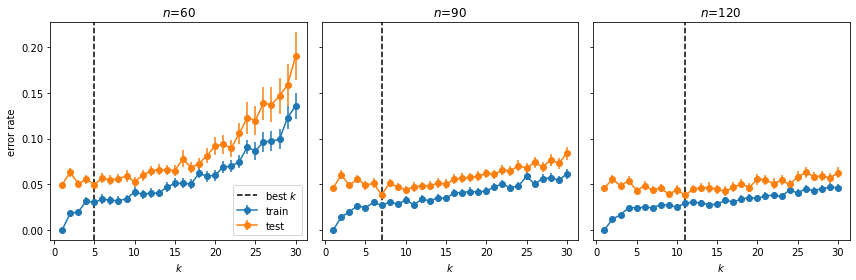

In [13]:
ks = np.arange(1, max_k+1)
_, axs = plt.subplots(1, len(training_sizes), figsize=(4*len(training_sizes),4), tight_layout=True, sharey=True)
for i, frac in enumerate(training_sizes):
    z = reps**0.5/1.96
    axs[i].set_title(f'$n$={round(len(iris.data)*frac)}')
    axs[i].errorbar(ks, train_results_trainsize[i].mean(axis=0), yerr=train_results_trainsize[i].std(axis=0)/z, marker='o', label='train')
    axs[i].errorbar(ks, test_results_trainsize[i].mean(axis=0), yerr=test_results_trainsize[i].std(axis=0)/z, marker='o', label='test')
    axs[i].axvline(ks[best_ks[i]], color='black', linestyle='--', label='best $k$')
    axs[i].set_xlabel('$k$')
axs[0].legend()    
axs[0].set_ylabel('error rate')
plt.show()

## Discussion

#### Task F: Summarise what you have learned by briefly answering the following questions.

**What is the purpose of the Bootstrap when evaluating machine learning algorithms and how should you choose the number of Bootstrap repetitions?**

*The Bootstrap can be used to simulate the uncertainty of the predictions in terms of the used training data. In principle, the more repetitions, the better the results will be. On the other hand, the experiment will take more time. So in a given scenario we would choose the number of repetitions only large enough to reduce the error bars sufficiently to draw conclusions.*

**How does the number of available training data points influence the choice of the hyper-parameter $k$ in $k$-NN, and what is the reason for this?**

*More training points allow to use larger values of $k$ to have a smoother prediction scores that can reduce the influence of noise / outliers.*